Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing Images:   0%|          | 0/4 [00:00<?, ?it/s]

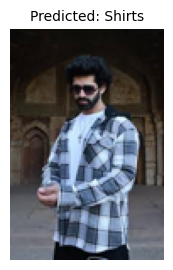

Image: images.jpg, Prediction: Shirts


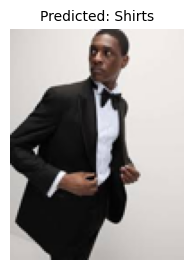

Image: images (1).jpg, Prediction: Shirts


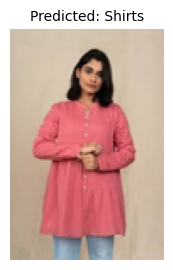

Image: images (2).jpg, Prediction: Shirts


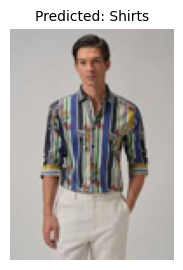

Processing Images:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

Image: images (3).jpg, Prediction: Shirts


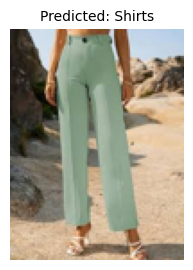

Image: download.jpg, Prediction: Shirts


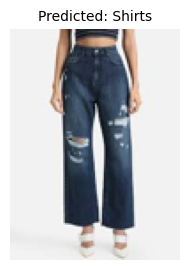

Image: download (1).jpg, Prediction: Shirts


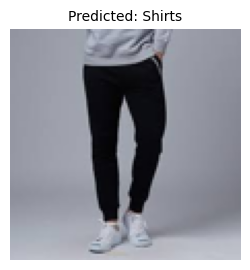

Image: images (4).jpg, Prediction: Shirts


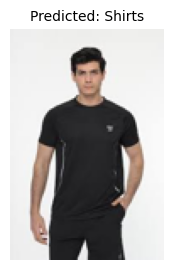

Processing Images:  50%|█████     | 2/4 [00:00<00:00,  2.71it/s]

Image: images (5).jpg, Prediction: Shirts


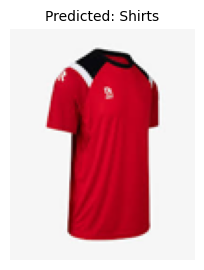

Image: images (6).jpg, Prediction: Shirts


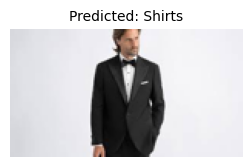

Image: images (7).jpg, Prediction: Shirts


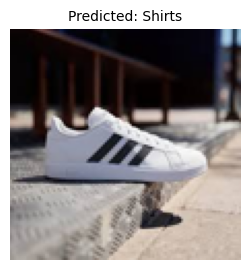

Image: download (2).jpg, Prediction: Shirts


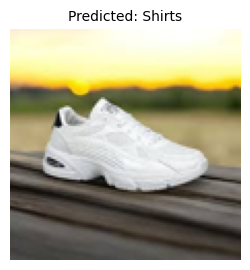

Processing Images:  75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]

Image: download (3).jpg, Prediction: Shirts


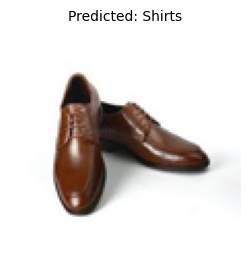

Image: download (4).jpg, Prediction: Shirts


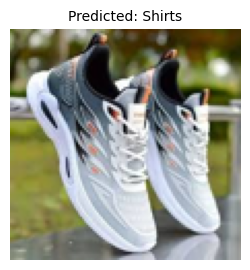

Image: images (8).jpg, Prediction: Shirts


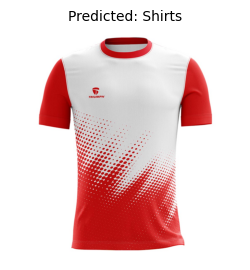

Processing Images: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

Image: RunJerChMeStyA07-1.jpg, Prediction: Shirts

Results saved to /content/drive/MyDrive/ML/Masked Models/Inference/predictions.csv


In [16]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm
from google.colab import drive
import torchvision.models as models
import matplotlib.pyplot as plt

drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/ML/Masked Models/Topwear Classification/Topwear_93.3%_resnet101.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=False)
num_classes = 5
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load the full state dict first
state_dict = torch.load(model_path, map_location=device)

# Filter out the weights for the final classification layer
# This assumes the original model checkpoint either had 'fc' or 'classifier' for the final layer.
# Since your error shows keys like 'classifier.1', we filter those out.
# If your saved model was trained on a standard ResNet structure and you just finetuned the final layer,
# the keys might be 'fc.weight' and 'fc.bias'. We filter both possibilities for safety.
filtered_state_dict = {k: v for k, v in state_dict.items() if not (k.startswith('fc.') or k.startswith('classifier.'))}


# Load the filtered weights into the model.
# strict=False is crucial here because the state_dict is missing the keys for the new 'fc' layer.
model.load_state_dict(filtered_state_dict, strict=False)

model.to(device)
model.eval()

# --- Load Class Labels ---
class_labels = {i: f"Class {i}" for i in range(num_classes)}
labels_path = "/content/drive/MyDrive/ML/Masked Models/Topwear Classification/Topwear.txt"
if os.path.exists(labels_path):
    with open(labels_path, "r") as f:
        class_labels = {i: line.strip() for i, line in enumerate(f.readlines())}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx], img_path


image_folder = '/content/drive/MyDrive/ML/Masked Models/Inference/photos'
output_folder = '/content/drive/MyDrive/ML/Masked Models/Inference/Prediction'
os.makedirs(output_folder, exist_ok=True)

batch_size = 4

dataset = ImageDataset(image_folder, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# --- Run Inference & Save Images in Class Folders ---
results = []

with torch.no_grad():
    for batch_images, batch_filenames, batch_paths in tqdm(dataloader, desc="Processing Images"):
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        _, preds = torch.max(outputs, 1)

        for filename, img_path, pred in zip(batch_filenames, batch_paths, preds.cpu().numpy()):
            class_name = class_labels.get(pred, f"Class {pred}")
            results.append([filename, pred, class_name])

            # Use the original PIL Image object before transform for displaying and saving
            img_pil = Image.open(img_path).convert("RGB")
            img_pil = img_pil.resize((img_pil.width // 2, img_pil.height // 2))

            plt.figure(figsize=(3, 3))
            plt.imshow(img_pil) # Use the PIL image for plotting
            plt.title(f"Predicted: {class_name}", fontsize=10)
            plt.axis("off")
            plt.show()

            # Save image in corresponding class folder
            class_folder = os.path.join(output_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)
            img_pil.save(os.path.join(class_folder, filename)) # Use the PIL image for saving

            print(f"Image: {filename}, Prediction: {class_name}")

# --- Save Results to CSV ---
output_csv = "/content/drive/MyDrive/ML/Masked Models/Inference/predictions.csv"
df = pd.DataFrame(results, columns=["Filename", "Predicted Class ID", "Predicted Class"])
df.to_csv(output_csv, index=False)
print(f"\nResults saved to {output_csv}")